# Miniproject 2: Chatbot

## Introduction

### Description

Developing a model employing ANN on real-world data requires going through several major steps, each of which with 
important design choices that directly impact the final results. 
In this project, we guide you through these choices starting from a large database of 
[conversations](http://parl.ai/downloads/personachat/personachat.tgz) to a functional chatbot. 

### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night and make sure you save (and load) your data and models.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. 
Please ensure that your notebook is fully executed before handing it in. 

### Submission 

You should submit your notebook through the Moodle page submission tool. You should work in teams of two people and each member should submit the same notebook to Moodle.



## Functions and imports

For your convenience we import some libraries and provide some functions below. Fill in your names, sciper numbers and run the following cell.

In [1]:
names = {'student_1': "Mahammad Shirinov",
         'student_2': "Stephen Zhao"}

sciper = {'student_1': 305483, 
          'student_2': 305545}

seed = sciper['student_1']+sciper['student_2']

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os, sys
import copy
import random

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN, Bidirectional, Embedding, BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping


def getRawDataFromFile(datapath="data/personachat/", file="train_both_revised.txt"):
    
    f = open(datapath+file)

    conversations = []
    current_conversation = []
    
    for l, line in enumerate(f):
        #print(l, line)
        if "persona:" in line:
            if len(current_conversation) > 1:
                conversations.append(current_conversation)
            current_conversation = [] 
            continue

        #remove numberings
        processed_line = line.split(' ')
        processed_line = " ".join(processed_line[1:])
        line = processed_line
        #print(line)

        conv = line.split('\t')    
        q = conv[0]
        a = conv[1]
        current_conversation.append(q)
        current_conversation.append(a)
    
    return conversations 

Using TensorFlow backend.


In [231]:
# Good old helpers from MP1
def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy (loss)')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history['loss'], label = "training")
    ax1.plot(history['val_loss'], label = "validation")
    ax2.plot(history['acc'], label = "training")
    ax2.plot(history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


## Data visualization and preprocessing

Here we will process and visualize the data.


### Parse raw data 

Download the dataset on http://parl.ai/downloads/personachat/personachat.tgz. Unpack it and add it to your project folder. Read and run the getRawDataFromFile function (if needed, modify the default path). It extracts the conversations.

**Output** Display two randomly selected conversations. [1 pt]

In [2]:
conversations_train_both_revised = getRawDataFromFile()

In [3]:
for i, conv in enumerate(random.choices(conversations_train_both_revised, k=2)):
    print('------- Conversation', i)
    for j, sent in enumerate(conv):
        print('-' if j % 2 == 0 else '+', sent)

------- Conversation 0
- hello , how are you ? i so glad i bought a house with my lovey .
+ hi ! i am arnold . i live with my parents .
- where do you live ? i am from portland , oregon .
+ i get to drink lots of orange juice cos i live in florida !
- talking about drink , i brew beer with my gay partner .
+ is that like my classmate joey who has two dads ?
- yes , it is like that . are you in college , if so what is your major ?
+ i am in 5th grade . i only know about college from tv .
- wow , you are very young . i thought you would be older .
+ you must be a grown up .
- i am . were your family able to evacuate florida when hurricane irma came ?
+ we are staying with grandma . she lets me watch cartoons .
------- Conversation 1
- hello . what do you do ?
+ hi . nice to meet you . i am a hairdresser and own a salon . you ?
- i own a cupcake bakery
+ do you have to keep your hair up all the time at your job ?
- i prefer to keep it up . more sanitary
+ makes sense . i would hate that ,

### Extract word tokens

Let's start looking at our data. 

**Code** Compute the set of unique words (dictionary) in all sentences along with the number of occurences of each of these words. HINT: each word is separated by a space character, use the python string.split(' ') function to separate words. Consider punctuations as 'words'. [1 pt]


In [4]:
words_frequency = {}
for conv in conversations_train_both_revised:
    for sent in conv:
        words = sent.split(' ')
        for word in words:
            if word in words_frequency:
                words_frequency[word] += 1
            else:
                words_frequency[word] = 1

In [5]:
for word in list(words_frequency)[:10]:
    print(word, words_frequency[word])

hi 4485
, 39499
how 10903
are 17934
you 48295
doing 4250
? 43768
i 103476
am 24797
getting 823


**Figure** In a bar plot, show the first 75 most frequent words (x-axis) and their number of occurences (y-axis). [1 pt]

In [6]:
from heapq import nlargest
most_frequent_words = nlargest(75, words_frequency, key=words_frequency.get)
print(most_frequent_words[:10])

['i', '.', 'you', '?', ',', 'a', 'to', 'do', 'is', 'my']


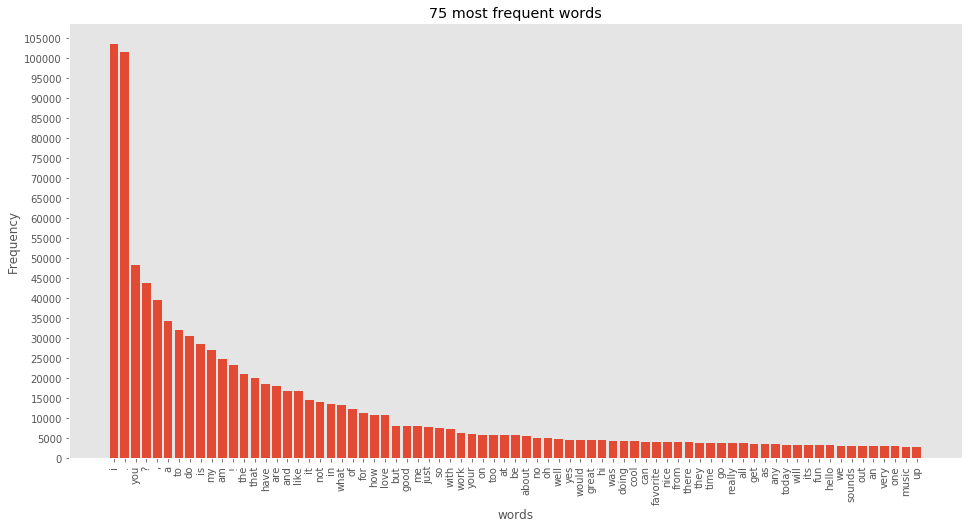

In [7]:
plt.figure(figsize=(16,8))
plt.title('75 most frequent words')
plt.bar(most_frequent_words, [words_frequency[x] for x in most_frequent_words])
plt.xticks(np.arange(0, 75), most_frequent_words, rotation='vertical')
plt.yticks(np.arange(0, words_frequency[most_frequent_words[0]]+5000, 5000))
plt.xlabel('words')
plt.ylabel('Frequency')
plt.show()

**Figure** In another bar plot, show the 75 least frequent words (x-axis) and their number of occurences (y-axis). [1 pt] 

In [8]:
from heapq import nsmallest
least_frequent_words = nsmallest(75, words_frequency, key=words_frequency.get)
print(least_frequent_words[:10])

['100m', 'footfall', 'mojitos', 'asians', 'taos', 'braids', 'clot', 'breaker', 'ventured', 'smash']


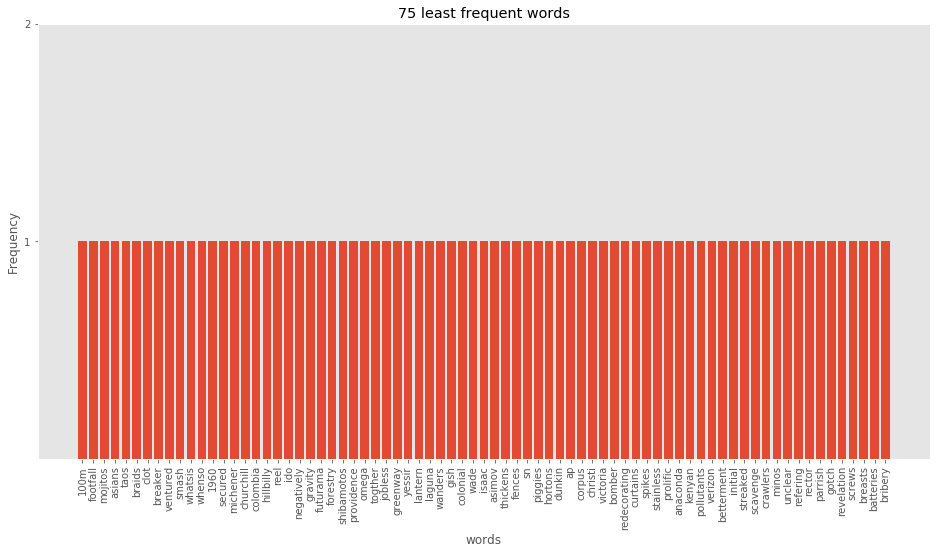

In [9]:
plt.figure(figsize=(16,8))
plt.title('75 least frequent words')
plt.bar(least_frequent_words, [words_frequency[x] for x in least_frequent_words])
plt.xticks(np.arange(0, 75), least_frequent_words, rotation='vertical')
plt.yticks([1, 2])
plt.xlabel('words')
plt.ylabel('Frequency')
plt.show()

**Figure** In a log-log scale, plot the sorted word index (x-axis) vs their respective count (y-axis). [1 pt]

In [10]:
word_counts = sorted(list(words_frequency.values()), reverse=True)

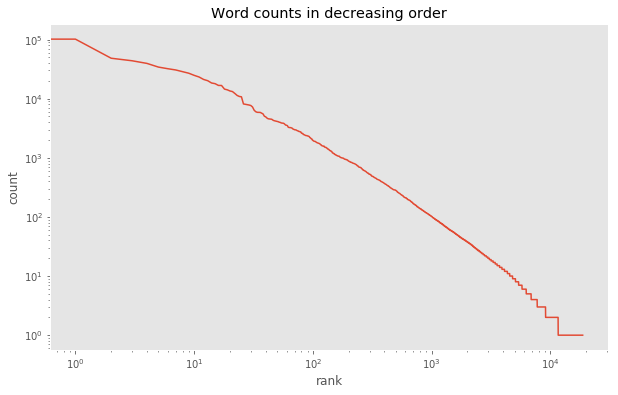

In [12]:
plt.figure(figsize=(10,6))
plt.title('Word counts in decreasing order')
plt.loglog(word_counts)
plt.xlabel('rank')
plt.ylabel('count')
plt.show()

**Question** Relate the sorted word count distribution with Zipf's law.
Argue using the log-log plot. [1 pt]

**Answer** From Wikipedia: "Zipf's law states that given a large sample of words used, the frequency of any word is inversely proportional to its rank in the frequency table. So word number n has a frequency proportional to 1/n."
Indeed, our data seems to follow Zipf's law, since the word count, plotted in decreasing order in a loglog scale resembles a line with a negative slope, as would the function $f(x) = \frac{c}{x}$.




**Question** How many words appear only once in the entire dataset? [1 pt]

**Answer** 7080.

In [13]:
print(sum([1 for x in words_frequency if words_frequency[x] == 1]))

7080


### Filtering

We suggest to filter your data by removing sentences containing rare words. 


**Code** To achieve that, you should create a new dataset where sentences containing rare words (words that occur less than N times in the dataset) are removed. Keep at least 50'000 sentences (depending on your computing power, you can keep more). 
HINT: Start by updating the dictionary accordingly and then remove any sentence that contains at least a single word that is not in the dictionary of words. [2 pts]

Dictionary size before filtering

In [14]:
len(words_frequency)

18673

Number or sentences before filtering:

In [15]:
sum([len(conv) for conv in conversations_train_both_revised])

131424

In [16]:
len(conversations_train_both_revised)

8938

In [17]:
N = 104
rare_words = [word for word in words_frequency if words_frequency[word] < N]
new_dictionary = copy.deepcopy(words_frequency)
for word in rare_words:
    del new_dictionary[word]

In [18]:
len(new_dictionary)

987

In [19]:
filtered_dataset_train = copy.deepcopy(conversations_train_both_revised)
for conv in filtered_dataset_train:
    for sent in conv[::-1]:
        ind = 0
        for word in sent.split(' '):
            if word not in new_dictionary:
                ind += 1
        if ind > 0:
            conv.remove(sent)

In [20]:
sum([len(conv) for conv in filtered_dataset_train])

50089

In [21]:
# remove empty conversations
for i in range(sum([1 for conv in filtered_dataset_train if len(conv) == 0])):
    filtered_dataset_train.remove([])

In [22]:
dictionary = new_dictionary
training_dataset = filtered_dataset_train

**Question**: How much did you reduce the number of unique words with your rare event suppression procedure? [1 pt]
    
**Answer**: We reduced the nunmber of words in the dictionary to 987.

**Question**: How many sentences are in your filtered and original dataset? [1 pt]

**Answer**: There are 50,089 sentences in the filtered dataset, as opposed to 131,424 in the original one.

**Question**: What is the impact on learning and generalization of removing sentences with rare words from your dataset? [2 pt]

**Answer**: Reducing the size of the dataset will speed up the learning phase, and removing rare words will make sure that the model can generalize better (since 'unrare' words are more likely to come up in future data, so better to learn those)

### Tokenization and padding

Now you will transform our filtered data into a format that is understandable by an ANN. To achieve that, you should transform words to integers, where single integers in the range [1,size of the dictionary] are mapped to single words in your dictionary. This process is commonly named 'tokenization'. In addition, we will keep the value 0 to a specific artificial word 'PADD' that will be used to account for the variable length of sentences and add to each sentence a 'START' and an 'END' word. 

**Code** Start by adding the three artificial words to your dictionary (list of possible tokens) and then translate every sentences to a list of integers. 
HINT: use the Python List index() method. [2 pts]

In [23]:
words_list = ['PADD']
words_list.extend(sorted(list(dictionary.keys())))
words_list.extend(['START', 'END'])
print(words_list.index('START'))

988


In [24]:
def tokenize(sent):
    tokenization = [words_list.index('START')]
    for word in sent.split(' '):
        tokenization.append(words_list.index(word))
    tokenization.append(words_list.index('END'))
    return tokenization

In [120]:
def detokenize(sent):
    plaintext = []
    for word in sent[0]:
        plaintext.append(words_list[word])
    return ' '.join(plaintext)

In [25]:
data_train = []
for conv in training_dataset:
    data_train.append([tokenize(sent) for sent in conv])

**Figure** Use the violinplot to show the density of tokenized sentences length. [1pt]

In [26]:
train_sentences = [z for c in data_train for z in c]

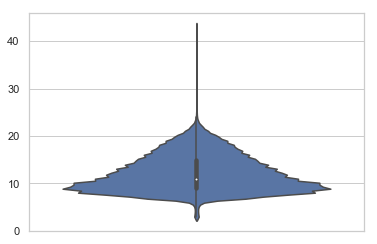

In [27]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.violinplot(y=[len(z) for z in train_sentences])

**Code** From this figure, select a maximum number (=maxlen) of tokens for which most of the sentences have less. Padd (and eventually truncate) all sentences with the 'PADD' token (value 0 in the integer representation) until all tokenized sentences have the same length (maxlen).
HINT: use the pad_sequences function from keras.preprocessing.sequence [2 pts]

In [40]:
maxlen = 23

In [28]:
len([len(z) for z in train_sentences if len(z) > maxlen])

45

we can disregard these sentences for the sake of a smaller input dimension (we have 50089 sentences in our dataset, still > 50,000)

In [29]:
train_sentences = keras.preprocessing.sequence.pad_sequences(train_sentences, maxlen=maxlen, padding='post', dtype='int32', value=0)

In [30]:
train_sentences

array([[988, 978, 565, ...,   0,   0,   0],
       [988, 832, 450, ...,   0,   0,   0],
       [988, 929, 450, ...,   0,   0,   0],
       ...,
       [988, 405,   3, ...,   0,   0,   0],
       [988, 437,  46, ...,   0,   0,   0],
       [988, 437, 953, ...,   0,   0,   0]], dtype=int32)

**Code** Check that you can recover the original sentence. Randomly select two sentences from your integer and padded representation and translate them back using your dictionary. [1 pt]

In [31]:
np.shape(train_sentences)

(50089, 23)

In [32]:
choices = np.random.randint(np.shape(train_sentences)[0], size=2)
rand_sents = train_sentences[choices,:]
for sent in rand_sents:
    print(sent)
    text = ' '.join([words_list[i] for i in sent])
    print(text)

[988 832 450 208   3 611 169 588 359 946 566 220 136 566 546  50 437  63
 182 989   0   0   0]
START that is cool . only child not good with my dad but my mom and i are close END PADD PADD PADD
[988 585 840 210 153 484 989   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0]
START no they could care less END PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD


### Saving

Now is a good time to save your data (end of processing). An example code using the pickle library is shown below.


In [33]:
import pickle

#save
with open("data.pkl", "wb") as file:
    pickle.dump([data_train, train_sentences, dictionary, words_list], file)

In [39]:
import pickle
#load
with open("data.pkl", "rb") as file:
    [data_train, train_sentences, dictionary, tokens] = pickle.load(file)
# name 'tokens' is adopted from now on for what we previouslt called words_list

In [43]:
train_sentences[:10]

array([[988, 978, 565,  91, 895, 296,   3, 435, 450, 608, 597, 566, 301,
        413,   3, 989,   0,   0,   0,   0,   0,   0,   0],
       [988, 832, 450,  76,   3, 241, 978, 389,  17, 301, 714, 613, 853,
        597, 970,  16, 989,   0,   0,   0,   0,   0,   0],
       [988, 929, 450, 982, 301, 533, 856, 261,  16, 989,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [988, 405,   2, 429,  63, 978, 246, 857,  16, 989,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [988, 437,  46, 774, 853, 946, 566,  10, 744, 929,  63, 978, 885,
        856, 989,   0,   0,   0,   0,   0,   0,   0,   0],
       [988, 961,   2, 327, 744,   3, 458, 914, 340, 597, 851,   3, 989,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [988, 437,  32,   3, 929, 241, 978, 241, 324,  17, 498,  16, 989,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [988, 832, 450, 208, 566, 546, 243, 833, 705, 841, 989,   0,   0,
   

## Building and training generative models of language

### RNN vs LSTM vs GRU 

Build, train and compare generative models of language based on RNNs with different recurrent units (SimpleRNN, GRU and LSTM). 

The target of the network will be to approximate the word transition probabilities Pr(word[n+1]|H[n]) with H[n]=f(word[:n]) being the hidden state of the network.  

**code** You should complete the proposed model (using the Keras API rather than the Sequential model for more flexibility). Be sure to understand each line. The embedding layer allows to transform an integer to a dense vector. That would be our input to the recurrent network - each sentence is mapped to a sequence of vectors, each representing a single word. You can then design your own readout(s) and output layers. By default, use the proposed meta parameters. You can adapt them if you have more or less computing power (32 epochs should take around 30 minutes). [2 pts]

**Question** How will your networks deal with the artificial word 'PADD' that you added at the end of each sentences  [2 pts]

**Answer** It will probably predict only the word 'PADD's after 'PADD', since this is the only thing it has seen in the training data.

**code** Then train three different networks with the same architecture but using different recurrent units (simpleRNN, GRU and LSTM). Save the learning history (training/validation loss and accuracy for each epoch) as well as the models. [1 pt]

In [36]:
#Meta-parameters
embedding_size = 128
hidden_size = 64
dropout = 0.
recurrent_dropout = 0.

batch_size = 64
epochs = 32
validation_split = 0.2

dataset_cut = -1

In [37]:
I = {}
E = {}
H = {}
R = {}
Y = {}
models = {}
logs = {}

In [55]:
from keras.utils import to_categorical
# train_sentences[:,:-1].shape # first 22 words

X = train_sentences
T = to_categorical(train_sentences)

In [56]:
T.shape

(50089, 23, 990)

### SimpleRNN

In [76]:
#Model suggestion

I['RNN'] = Input(shape=(maxlen-1,), name="input")
E['RNN'] = Embedding(len(tokens), embedding_size, mask_zero=True, name="embedding")

#your network here
H['RNN'] = SimpleRNN(hidden_size, dropout=dropout, return_sequences=True,
                     recurrent_dropout=recurrent_dropout, name='hidden')(E['RNN'](I['RNN'])) #... Recurrent layer(s)

R['RNN'] = TimeDistributed(Dense(hidden_size, activation='linear'), name='readout')(H['RNN']) #... Readout
Y['RNN'] = TimeDistributed(Dense(len(tokens), activation='softmax'), name='output')(R['RNN']) #... Output



models['RNN'] = Model(inputs = [I['RNN']], outputs = [Y['RNN']])
models['RNN'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['RNN'].summary()

print(X[:,:-1].shape, T[:,1:].shape)
logs['RNN'] = models['RNN'].fit({'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]}, 
                                    epochs=epochs,
                                    validation_split=validation_split, 
                                    batch_size=batch_size).history

#save
with open("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['RNN'], file)
models['RNN'].save("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 22)                0         
_________________________________________________________________
embedding (Embedding)        (None, 22, 128)           126720    
_________________________________________________________________
hidden (SimpleRNN)           (None, 22, 64)            12352     
_________________________________________________________________
readout (TimeDistributed)    (None, 22, 64)            4160      
_________________________________________________________________
output (TimeDistributed)     (None, 22, 990)           64350     
Total params: 207,582
Trainable params: 207,582
Non-trainable params: 0
_________________________________________________________________
(50089, 22) (50089, 22, 990)
Train on 40070 samples, validate on 10018 samples
Epoch 1/32
40070/40070 [==============================] -

### LSTM

In [208]:
#Model suggestion

I['LSTM'] = Input(shape=(maxlen-1,), name="input")
E['LSTM'] = Embedding(len(tokens), embedding_size, mask_zero=True, name="embedding")

#your network here
H['LSTM'] = LSTM(hidden_size, dropout=dropout, return_sequences=True,
                     recurrent_dropout=recurrent_dropout, name='hidden')(E['LSTM'](I['LSTM'])) #... Recurrent layer(s)

R['LSTM'] = TimeDistributed(Dense(hidden_size, activation='linear'), name='readout')(H['LSTM']) #... Readout
Y['LSTM'] = TimeDistributed(Dense(len(tokens), activation='softmax'), name='output')(R['LSTM']) #... Output



models['LSTM'] = Model(inputs = [I['LSTM']], outputs = [Y['LSTM']])
models['LSTM'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['LSTM'].summary()

print(X[:,:-1].shape, T[:,1:].shape)
logs['LSTM'] = models['LSTM'].fit({'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]}, 
                                    epochs=epochs,
                                    validation_split=validation_split, 
                                    batch_size=batch_size).history

#save
with open("LSTMmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['LSTM'], file)
models['LSTM'].save("LSTMmodel_"+str(embedding_size)+'_'+str(hidden_size))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 22)                0         
_________________________________________________________________
embedding (Embedding)        (None, 22, 128)           126720    
_________________________________________________________________
hidden (LSTM)                (None, 22, 64)            49408     
_________________________________________________________________
readout (TimeDistributed)    (None, 22, 64)            4160      
_________________________________________________________________
output (TimeDistributed)     (None, 22, 990)           64350     
Total params: 244,638
Trainable params: 244,638
Non-trainable params: 0
_________________________________________________________________
(50089, 22) (50089, 22, 990)
Train on 40070 samples, validate on 10018 samples
Epoch 1/32
40070/40070 [==============================] -

### GRU 1x64

In [209]:
#Model suggestion

I['GRU'] = Input(shape=(maxlen-1,), name="input")
E['GRU'] = Embedding(len(tokens), embedding_size, mask_zero=True, name="embedding")

#your network here
H['GRU'] = GRU(hidden_size, dropout=dropout, return_sequences=True,
                     recurrent_dropout=recurrent_dropout, name='hidden')(E['GRU'](I['GRU'])) #... Recurrent layer(s)

R['GRU'] = TimeDistributed(Dense(hidden_size, activation='linear'), name='readout')(H['GRU']) #... Readout
Y['GRU'] = TimeDistributed(Dense(len(tokens), activation='softmax'), name='output')(R['GRU']) #... Output



models['GRU'] = Model(inputs = [I['GRU']], outputs = [Y['GRU']])
models['GRU'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['GRU'].summary()

print(X[:,:-1].shape, T[:,1:].shape)
logs['GRU'] = models['GRU'].fit({'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]}, 
                                    epochs=epochs,
                                    validation_split=validation_split, 
                                    batch_size=batch_size).history

#save
with open("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['GRU'], file)
models['GRU'].save("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 22)                0         
_________________________________________________________________
embedding (Embedding)        (None, 22, 128)           126720    
_________________________________________________________________
hidden (GRU)                 (None, 22, 64)            37056     
_________________________________________________________________
readout (TimeDistributed)    (None, 22, 64)            4160      
_________________________________________________________________
output (TimeDistributed)     (None, 22, 990)           64350     
Total params: 232,286
Trainable params: 232,286
Non-trainable params: 0
_________________________________________________________________
(50089, 22) (50089, 22, 990)
Train on 40070 samples, validate on 10018 samples
Epoch 1/32
40070/40070 [==============================] -

In [ ]:
#load
with open("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "rb") as file:
    RNNmodel_log = pickle.load(file)
RNNmodel = load_model("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size))

**Question** How can you use this network to approximate the word transition probabilities? What will be the inputs and targets of the network at each batch? Give the input/output tensor dimensions. [2 pts]

**Answer**

**Figure** Show the learning curves (training and validation loss) for the different recurrent units. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the different recurrent units. [1 pt]

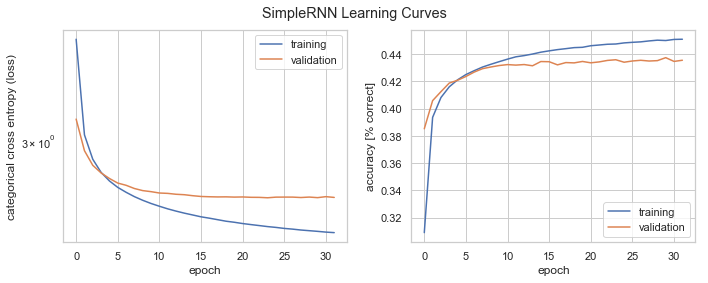

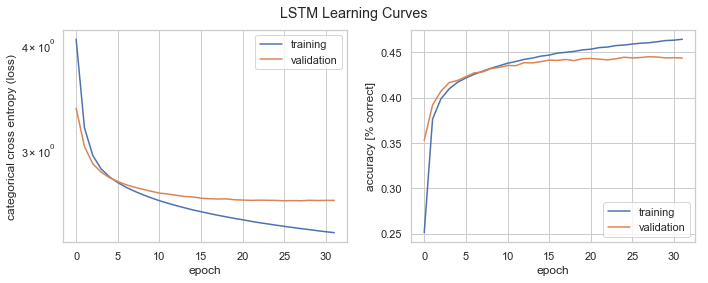

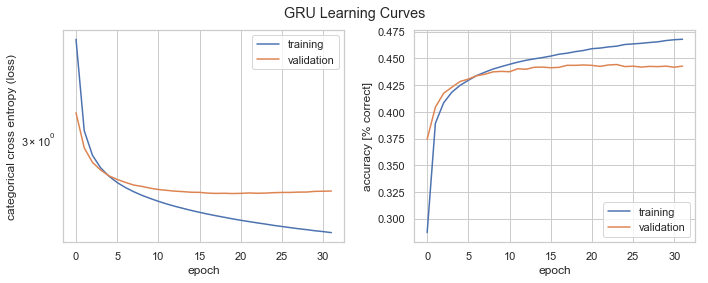

In [232]:
plot_history(logs['RNN'], "SimpleRNN Learning Curves")
plot_history(logs['LSTM'], "LSTM Learning Curves")
plot_history(logs['GRU'], "GRU Learning Curves")
pass

**Question:** Which recurrent unit yields the best validation accuracy? Which is the fastest learner? [1 pt]

**Answer**: In terms of validation accuracy, we have LSTM > GRU > SimpleRNN, with only tiny differences between LSTM and GRU. If we evaluate on how fast a model reaches a certain validation accuracy (0.4350 and 0.4400 chosen for comparison in this case), GRU is the fastest learner, and SimpleRNN is the slowest.

**Question:** Do you observe an overfitting effect? Where and for which case? Give a possible explanation. [1 pt] 

**Answer**: 

**Question:** Suggest one option modifying your dataset to decrease overfitting. [1 pt]

**Answer**: 

**Question:** Suggest one possible option modifying your network to decrease overfitting. [1 pt]

**Answer**: 

**Question:** Suggest one possible option modifying the training modalities to counter overfitting. [1 pt]   

**Answer**: 

### Optimal network size

Compare the learning curves for three networks with 64 (previous exercise), 128 and 256 GRUs (single layer) and one with two hidden layers of 64 GRUs. 

**Code** Build and train the networks. Apply EarlyStopping (monitor='val_acc', min_delta=0.001, patience=2). Use transfer learning, do not train from scratch your embedding layer, rather re-use the embedding layer from your best performing network in the last exercise. [4 pts]


### GRU 1x128

In [210]:
#Model suggestion

I['GRU_128'] = Input(shape=(maxlen-1,), name="input")
E['GRU_128'] = Embedding(len(tokens), embedding_size, weights=E['LSTM'].get_weights(), mask_zero=True, name="embedding", trainable=False)

#your network here
H['GRU_128'] = GRU(128, dropout=dropout, return_sequences=True,
                     recurrent_dropout=recurrent_dropout, name='hidden')(E['GRU_128'](I['GRU_128'])) #... Recurrent layer(s)

R['GRU_128'] = TimeDistributed(Dense(hidden_size, activation='linear'), name='readout')(H['GRU_128']) #... Readout
Y['GRU_128'] = TimeDistributed(Dense(len(tokens), activation='softmax'), name='output')(R['GRU_128']) #... Output



models['GRU_128'] = Model(inputs = [I['GRU_128']], outputs = [Y['GRU_128']])
models['GRU_128'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['GRU_128'].summary()

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=2)

print(X[:,:-1].shape, T[:,1:].shape)
logs['GRU_128'] = models['GRU_128'].fit({'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]}, 
                                    epochs=epochs,
                                    validation_split=validation_split, 
                                    batch_size=batch_size,
                                    callbacks=[early_stopping]).history

#save
with open("GRU_128model_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['GRU_128'], file)
models['GRU_128'].save("GRU_128model_"+str(embedding_size)+'_'+str(hidden_size))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 22)                0         
_________________________________________________________________
embedding (Embedding)        (None, 22, 128)           126720    
_________________________________________________________________
hidden (GRU)                 (None, 22, 128)           98688     
_________________________________________________________________
readout (TimeDistributed)    (None, 22, 64)            8256      
_________________________________________________________________
output (TimeDistributed)     (None, 22, 990)           64350     
Total params: 298,014
Trainable params: 171,294
Non-trainable params: 126,720
_________________________________________________________________
(50089, 22) (50089, 22, 990)
Train on 40070 samples, validate on 10018 samples
Epoch 1/32
40070/40070 [===========================

### GRU 1x256

In [211]:
#Model suggestion

I['GRU_256'] = Input(shape=(maxlen-1,), name="input")
E['GRU_256'] = Embedding(len(tokens), embedding_size, weights=E['LSTM'].get_weights(), mask_zero=True, name="embedding", trainable=False)

#your network here
H['GRU_256'] = GRU(256, dropout=dropout, return_sequences=True,
                     recurrent_dropout=recurrent_dropout, name='hidden')(E['GRU_256'](I['GRU_256'])) #... Recurrent layer(s)

R['GRU_256'] = TimeDistributed(Dense(hidden_size, activation='linear'), name='readout')(H['GRU_256']) #... Readout
Y['GRU_256'] = TimeDistributed(Dense(len(tokens), activation='softmax'), name='output')(R['GRU_256']) #... Output



models['GRU_256'] = Model(inputs = [I['GRU_256']], outputs = [Y['GRU_256']])
models['GRU_256'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['GRU_256'].summary()

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=2)

print(X[:,:-1].shape, T[:,1:].shape)
logs['GRU_256'] = models['GRU_256'].fit({'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]}, 
                                    epochs=epochs,
                                    validation_split=validation_split, 
                                    batch_size=batch_size,
                                    callbacks=[early_stopping]).history

#save
with open("GRU_256model_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['GRU_256'], file)
models['GRU_256'].save("GRU_256model_"+str(embedding_size)+'_'+str(hidden_size))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 22)                0         
_________________________________________________________________
embedding (Embedding)        (None, 22, 128)           126720    
_________________________________________________________________
hidden (GRU)                 (None, 22, 256)           295680    
_________________________________________________________________
readout (TimeDistributed)    (None, 22, 64)            16448     
_________________________________________________________________
output (TimeDistributed)     (None, 22, 990)           64350     
Total params: 503,198
Trainable params: 376,478
Non-trainable params: 126,720
_________________________________________________________________
(50089, 22) (50089, 22, 990)
Train on 40070 samples, validate on 10018 samples
Epoch 1/32
40070/40070 [===========================

### GRU 2x64

In [214]:
#Model suggestion

I['GRU2'] = Input(shape=(maxlen-1,), name="input")
E['GRU2'] = Embedding(len(tokens), embedding_size, weights=E['LSTM'].get_weights(), mask_zero=True, name="embedding", trainable=False)

#your network here
gru_layer_1 = GRU(hidden_size, dropout=dropout, return_sequences=True,
                     recurrent_dropout=recurrent_dropout, name='GRU_layer_1')(E['GRU2'](I['GRU2'])) #... Recurrent layer(s)
H['GRU2'] = GRU(hidden_size, dropout=dropout, return_sequences=True,
                     recurrent_dropout=recurrent_dropout, name='GRU_layer_2')(gru_layer_1)

R['GRU2'] = TimeDistributed(Dense(hidden_size, activation='linear'), name='readout')(H['GRU2']) #... Readout
Y['GRU2'] = TimeDistributed(Dense(len(tokens), activation='softmax'), name='output')(R['GRU2']) #... Output



models['GRU2'] = Model(inputs = [I['GRU2']], outputs = [Y['GRU2']])
models['GRU2'].compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
models['GRU2'].summary()

early_stopping = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=2)

print(X[:,:-1].shape, T[:,1:].shape)
logs['GRU2'] = models['GRU2'].fit({'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]}, 
                                    epochs=epochs,
                                    validation_split=validation_split, 
                                    batch_size=batch_size,
                                    callbacks=[early_stopping]).history

#save
with open("GRU2model_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
    pickle.dump(logs['GRU2'], file)
models['GRU2'].save("GRU2model_"+str(embedding_size)+'_'+str(hidden_size))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 22)                0         
_________________________________________________________________
embedding (Embedding)        (None, 22, 128)           126720    
_________________________________________________________________
GRU_layer_1 (GRU)            (None, 22, 64)            37056     
_________________________________________________________________
GRU_layer_2 (GRU)            (None, 22, 64)            24768     
_________________________________________________________________
readout (TimeDistributed)    (None, 22, 64)            4160      
_________________________________________________________________
output (TimeDistributed)     (None, 22, 990)           64350     
Total params: 257,054
Trainable params: 130,334
Non-trainable params: 126,720
________________________________________________________________

**Figure** Show the learning curves (training and validation loss) for the four models. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the four models. [1 pt]

**Question** List and briefly explain the differences in the learning curves for the different models? [2 pts]

**Answer**

**Question** What effect had EarlyStopping? Give one advantage and one drawback. [2 pts]

**Answer** EerlyStopping reduced the training time by a factor of 2 to 3, and it is a good way to stop overfitting. But it may have stopped too early for 1x128 GRU model, resulting in suboptimal training result; the learning curves suggest that there migh have been some room for further improvisation.

**Question** What is your best model? Why? [1 pt]

**Answer**


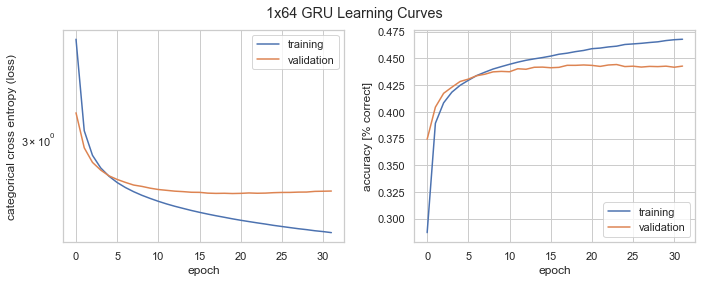

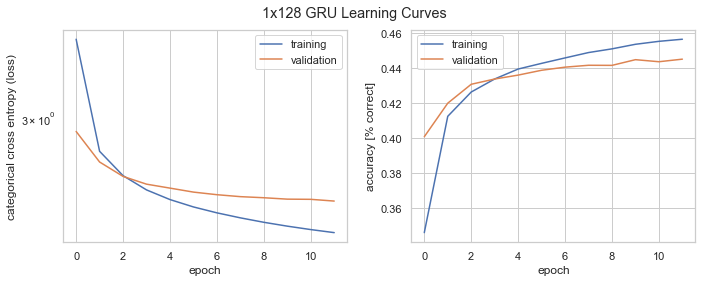

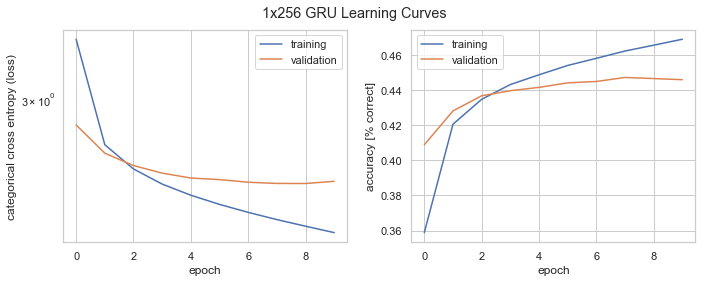

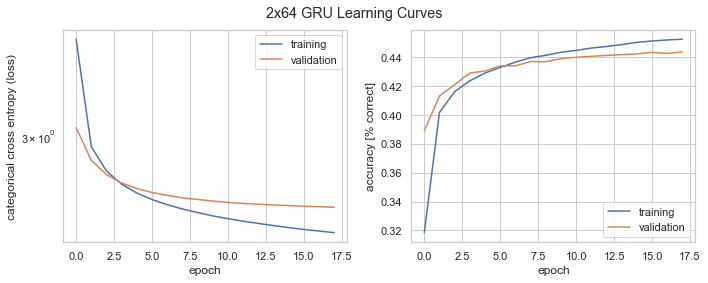

In [235]:
plot_history(logs['GRU'], '1x64 GRU Learning Curves')
plot_history(logs['GRU_128'], '1x128 GRU Learning Curves')
plot_history(logs['GRU_256'], '1x256 GRU Learning Curves')
plot_history(logs['GRU2'], '2x64 GRU Learning Curves')
pass

### Generate sentences

Now you will generate new sentences from your best performing model.

**Code** To achieve that, use the provided sample function below to generate new sentences from your model. You should start by constructing a sentence that starts with the 'START' artificial word and all other words being the 'PADD' artificial word. Then sample the first word from the corresponding probabilities given by your model. Add this word to the sentence and continue like this until you sample the 'END' artificial word or the maximum sentence length. [2 pts]

**Code** Generate 10 sentences for different sampling temperature in [0., 0.25, 0.5, 0.75, 1., 1.5., 2.]. [1 pt]

**7 Figures** For each temperature, use matplotlib imshow to plot the probablities of every word in one generated sentence (and only these words) at each time step. y-axis should be the words that are present in the sentence. x-axis the timesteps and the imshow value the probabilities given by the model for all words in the sentence at each timestep. Use the a colormap where 0 is white, e.g. cmap='Greys'. [2 pts]

**Code** Finally, seed your model with two different beginnings of max 4 words and let it generate 10 possible continuations (use sampling temperature of 1.). [2 pts]

**Question** What is the effect of sampling temperature on the generated sentences? [1 pt]

**Answer**

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 0 corresponds to? [1 pt] 

**Answer**

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 1. corresponds to? [1 pt] 

**Answer**

**Question** In terms of sampling a probability distribution, what does a very high sampling temperature corresponds to? [1 pt]

**Answer**

**Question** Based on the plotted word probabilities, explain how a sentence is generated. [2 pts]

**Answer**

**Question** Do you observe timesteps with more than one word with non-zero probability? How do these probable words relate in terms of language? [1 pt]

**Answer**

In [78]:
def sample(preds, temperature=1.):
    # helper function to sample an index from a probability array
    if temperature == 0.:
        return np.argmax(preds)
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


In [254]:
def gen_sent(temp=1.):
    test_sent = [988]
    test_sent.extend([0 for _ in range(maxlen-2)])
    test_sent = np.array([test_sent])
    for i in range(21):
        prediction = models['RNN'].predict(test_sent, steps=1)[0][-1] # TODO do we take [-1] or [i] ??
        word = sample(prediction, temperature=temp)
        test_sent[0][i+1] = word
        if word is 989:
            break

    if test_sent[-1] is not 989 or 0: # END or PADD
        prediction = models['RNN'].predict(test_sent, steps=1)[0][-1]
        word = sample(prediction, temperature=temp)
        np.append(test_sent[0], word)

    return test_sent

In [255]:
detokenize(gen_sent())

'START thank you ! where do you work END PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD'

# SOMETHING SEEMS TO BE WRONG WITH THE WAY WE GENERATE SENTENCES

# OR THE WAY WE BUILD THIS MATRIX 'A' (below)

In [262]:
for temp in [0., 0.25, 0.5, 0.75, 1., 1.5, 2.]:
    print(temp, detokenize(gen_sent(temp=temp)))

0.0 START i am good . how about you ? END PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD
0.25 START i am good . how are you ? END PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD
0.5 START hey , how are you doing today ? END PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD
0.75 START i am married and the kids and a cat END PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD
1.0 START no it is that i was so busy END PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD
1.5 START well sounds interesting , currently any more already and important choice . would rather swim currently book season are apple i
2.0 START currently well . state born , hanging tomorrow ? END PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD


Temperature: 0.0
START i am good . how about you ? END PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD
['i' 'am' 'good' '.' 'how' 'about' 'you' '?' 'END' 'PADD' 'PADD' 'PADD'
 'PADD' 'PADD' 'PADD' 'PADD' 'PADD' 'PADD' 'PADD' 'PADD' 'PADD']


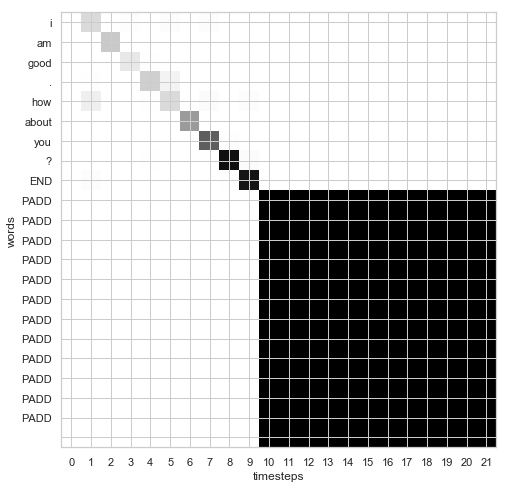

Temperature: 0.25
START i am doing well , how about you ? END PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD
['i' 'am' 'doing' 'well' ',' 'how' 'about' 'you' '?' 'END' 'PADD' 'PADD'
 'PADD' 'PADD' 'PADD' 'PADD' 'PADD' 'PADD' 'PADD' 'PADD' 'PADD']


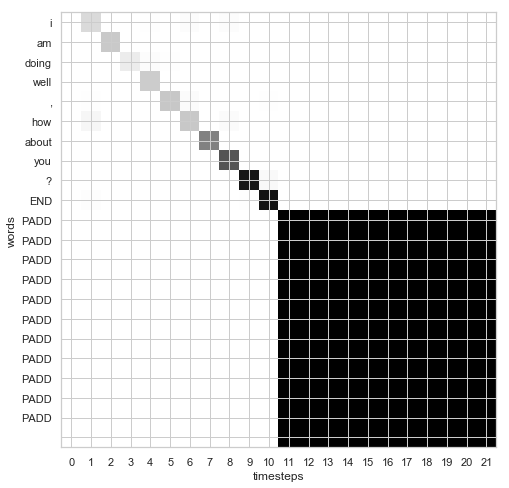

Temperature: 0.5
START i have never been to the beach . i love pizza END PADD PADD PADD PADD PADD PADD PADD PADD PADD
['i' 'have' 'never' 'been' 'to' 'the' 'beach' '.' 'i' 'love' 'pizza' 'END'
 'PADD' 'PADD' 'PADD' 'PADD' 'PADD' 'PADD' 'PADD' 'PADD' 'PADD']


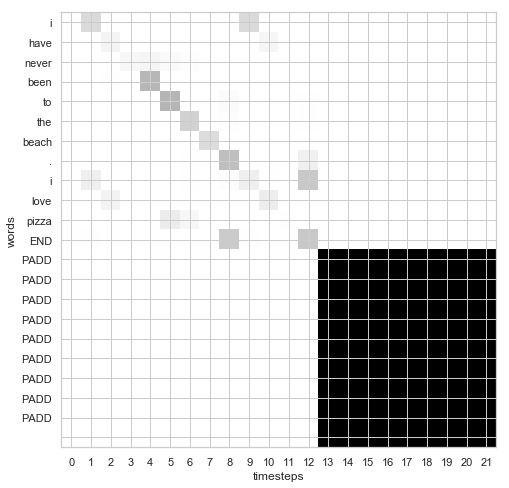

Temperature: 0.75
START i am good . how about yourself ? END PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD
['i' 'am' 'good' '.' 'how' 'about' 'yourself' '?' 'END' 'PADD' 'PADD'
 'PADD' 'PADD' 'PADD' 'PADD' 'PADD' 'PADD' 'PADD' 'PADD' 'PADD' 'PADD']


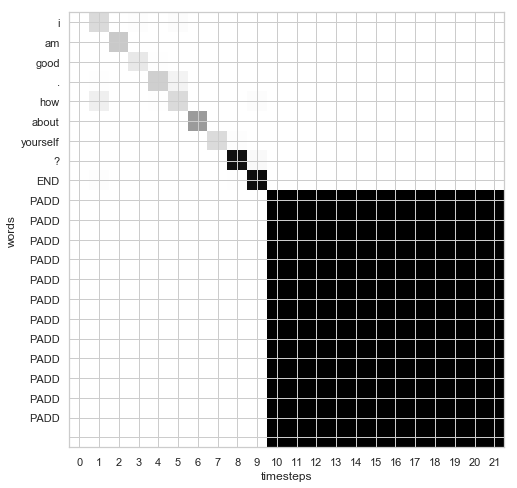

Temperature: 1.0
START pretty good , how about you ? END PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD PADD
['pretty' 'good' ',' 'how' 'about' 'you' '?' 'END' 'PADD' 'PADD' 'PADD'
 'PADD' 'PADD' 'PADD' 'PADD' 'PADD' 'PADD' 'PADD' 'PADD' 'PADD' 'PADD']


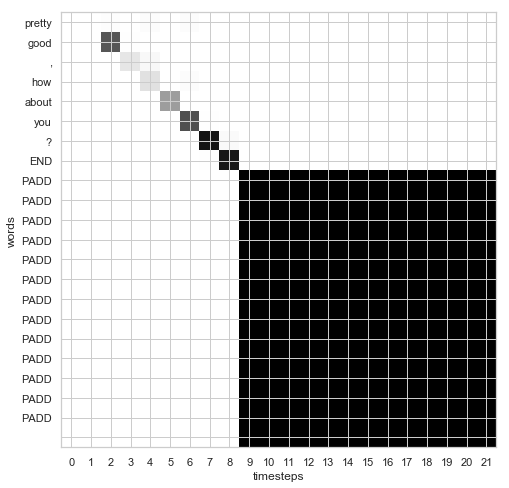

Temperature: 1.5
START i do work nice person to save my heart yet when cars END PADD PADD PADD PADD PADD PADD PADD PADD
['i' 'do' 'work' 'nice' 'person' 'to' 'save' 'my' 'heart' 'yet' 'when'
 'cars' 'END' 'PADD' 'PADD' 'PADD' 'PADD' 'PADD' 'PADD' 'PADD' 'PADD']


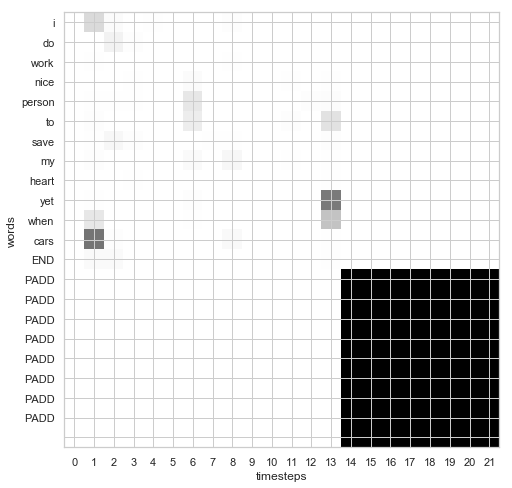

Temperature: 2.0
START hey good afternoon back where on weekends rock ? working real tv type nice though END PADD PADD PADD PADD PADD
['hey' 'good' 'afternoon' 'back' 'where' 'on' 'weekends' 'rock' '?'
 'working' 'real' 'tv' 'type' 'nice' 'though' 'END' 'PADD' 'PADD' 'PADD'
 'PADD' 'PADD']


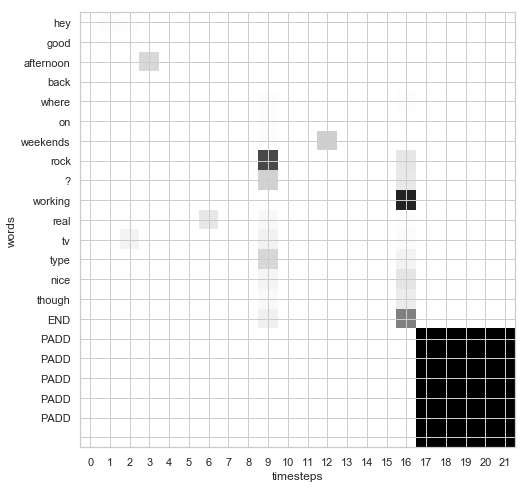

In [329]:
for temp in [0., 0.25, 0.5, 0.75, 1., 1.5, 2.]:
    test_sent = [988]
    test_sent.extend([0 for _ in range(maxlen-2)])
    test_sent = np.array([test_sent])
    
    
    for i in range(21):
        prediction = models['RNN'].predict(test_sent, steps=1)[0]
        word = sample(prediction[i], temperature=temp)
        test_sent[0][i+1] = word
        if word is 989:
            break

    if test_sent[-1] is not 989 or 0: # END or PADD
        prediction = models['RNN'].predict(test_sent, steps=1)[0]
        word = sample(prediction[-1], temperature=temp)
        np.append(test_sent[0], word)
    
    print('Temperature:', temp)
    print(detokenize(test_sent))
    
    A = prediction[:,test_sent].reshape((22,22))

    plt.figure(figsize=(8,8))
    plt.imshow(A, cmap='Greys')
    ax = plt.gca()
    xticks = np.arange(0,22)
    yticks = np.array([str(tokens[x]) for x in test_sent[0][1:]])
    print(yticks)
    ax.set_xticks(xticks)
    ax.set_yticks(xticks)
    ax.set_yticklabels(yticks)
    plt.xlabel('timesteps')
    plt.ylabel('words')
    plt.show()
#     plt.grid(True)

###  Word embedding visualization

Here, you are asked to visualize the embedding layer. 

**Code** To do that, project in 2D the embedding vectors for different words. Use t-SNE, a projection that conserve the neighborhood relationships between vectors. HINT: Build a Keras model that takes as input a list of words and outputs a list of vector embeddings as learned by your best performing model. Use t-SNE dimensionality reduction (from sklearn.manifold import TSNE). [2 pts]

**Figure** Plot the projection of the first 200 most frequent words in a 2D plot. On the plot, write the words. [2 pt] 

**Question** Do you observe clusters of words with similar meaning or role in language? Report three of them here. [1 pt]

**Answer**

**Question** Why is having similar vector representation for similar words a good approach for such models? Explain using the example clusters from before and argue in terms of prediction accuracy and/or generalization. [2 pts]

**Answer**

## Chatbot

Finally, you will construct a model with which you can chat. The network will take as input a sentence and output a response.

**Code** For that, you should go back to your original data and construct a new dataset containing pairs of sentences, where each pair is a sentence and its answer. Be careful to not include any pair of sentences that contains words not present in your filtered dictionary. [2 pts]

**Code** You should then tokenize, padd, truncate each sentence. Only the answers need the 'START' and 'END' artificial words. [1 pt]

We provide you with a possible model, you are welcome to change it. This model uses an LSTM layer to encode the first sentence (the context). The final state of this LSTM layer is transfered to initialize the state of a decoder LSTM layer from which the answer sentence will be generated. 

**Code** Train your chatbot model on your dataset. [1 pt]

**Code** Adapt your sentence generation code from before so that you can generate an answer given a context sentence from your model. [2 pts] 

**Code** After training, randomly select 10 context-answers pairs from your data and show both the real answer (the one from the data) and the generated one for two different sampling temperatures (e.g. 0.5 and 1.0). [2 pts]

**Question** How similar are the generated answers and the real ones? Does your model provide probable answers (given the dataset)? Report here one good and one bad example. [2 pts]

**Answer**

**Question** Which sampling temperature gives better answers? why? [2 pts]

**Answer**

**Question** Would it be good if your model was able to reproduce exactly each real answer? Why? [1 pt]

**Answer**

**Code** Entertain yourself with your model. Write some code to chat with your bot, let it discuss with itself, ... be creative! [2 **bonus** pts]




In [ ]:
context = Input(shape=(maxlen-2,), name="input_context")
shared_embedding = E['GRU']
context_embedding = shared_embedding(context)

encoder_y, encoder_h, encoder_c = LSTM(hidden_size, 
            return_sequences=False,
            return_state=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            go_backwards=True,
            name="encoder")(context_embedding)

answer = Input(shape=(maxlen-1,), name="input_answer")
answer_embedding = shared_embedding(answer)

decoder_input = answer_embedding
decoder = LSTM(hidden_size, 
            return_sequences=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            name="decoder")(answer_embedding, initial_state=[encoder_h, encoder_c])
# decoder2 = LSTM(hidden_size, 
#             return_sequences=True,
#             stateful=False,
#             dropout=dropout,
#             recurrent_dropout=recurrent_dropout,
#             name="decoder2")(decoder)

R = TimeDistributed(Dense(embedding_size, activation='relu'), name='readout')(decoder)
Y = TimeDistributed(Dense(len(tokens), activation='softmax'), name='output')(R)

Chatbot = Model(inputs = [context, answer], outputs = [Y])
Chatbot.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
Chatbot.summary()
